In [1]:
from copy import deepcopy
import tqdm

import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import GaussianMixture
from adaptive_mcmc.samplers import (
    base_sampler, mala, fishermala, hmc, hmcadaptive
)
from adaptive_mcmc.samplers.stopping_rule import NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils
from adaptive_mcmc.tools.metrics import compute_ess, compute_emd, compute_tv

2025-01-28 13:59:11.793871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738061951.806018   23746 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738061951.809029   23746 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    "mala": mala.MALAParams(
        sigma=1.0,
        sigma_lr=0.015,
        target_acceptance=0.574,
        device=device,
    ),
    "fisher_mala": fishermala.FisherMALAParams(dampening=10.),
    "hmc_vanilla": hmc.HMCParams(lf_step_count=5, lf_step_size=1.5, no_grad=True),
    "hmcadaptive_hutch": hmcadaptive.HMCAdaptiveParams(
        lf_step_count=5,
        lf_step_size=1.5,
        learning_rate=1e-3,
        truncation_level_prob=0.5,
        min_truncation_level=2,
        entropy_weight=1e1,
        entropy_weight_max=1e3,
        penalty_weight_max=1e1,
        penalty_weight=10.,
        penalty_weight_adaptive_rate=0,
        clip_grad_value=1e5,
        # iter_count=10000,
        # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    ),
}

In [14]:
chain_count = 50
dimensions = [32] #[8, 16, 32, 64, 128]
gaussian_count = 6
tv_threshold = 0.05
sample_count = 1000
sample_iter_limit = 1000
burn_in_iter_count = 1000
probe_period = 25000
cube = 1.
distance_to_mass_points = cube
tail_count_cap = 1000

# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(density_probe_count=500,
                       projection_count=25, tail_count_cap=tail_count_cap)

algs = {
    # "fisher_mala": fishermala.FisherMALAVanilla(
    #     pipeline=None,
    #     name="FisherMALA",
    #     sigma_burn_in_params=hparams["fisher_mala"].copy(),
    #     sigma_burn_in_iter_count=500,
    #     prec_burn_in_params=hparams["fisher_mala"].copy(),
    #     prec_burn_in_iter_count=burn_in_iter_count - 500,
    #     sample_iter_count=sample_iter_limit,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period
    # ),
    # "mala": mala.MALAVanilla(
    #     pipeline=None,
    #     name="MALA",
    #     sigma_burn_in_params=hparams["mala"].copy(),
    #     sigma_burn_in_iter_count=burn_in_iter_count,
    #     sample_iter_count=sample_iter_limit,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period,
    # ),
    # "hmc_vanilla": hmc.HMCVanilla(
    #     pipeline=None,
    #     name="HMCVanilla",
    #     params=hparams["hmc_vanilla"].copy(),
    #     sample_iter_count=sample_iter_limit,
    #     burn_in_iter_count=burn_in_iter_count,
    #     stopping_rule=stopping_rule,
    #     probe_period=probe_period,
    # ),
    "hmcadaptive_hutch": hmcadaptive.HMCAdaptive(
        pipeline=None,
        name="HMCAdaptiveHutch",
        params=hparams["hmcadaptive_hutch"].copy(),
        sample_iter_count=sample_iter_limit,
        burn_in_iter_count=burn_in_iter_count,
        stopping_rule=stopping_rule,
        probe_period=probe_period,
    ),
}

In [15]:
hist_data = {}
runtime = {
    dimension: dict()
    for dimension in dimensions
}
pure_runtime = deepcopy(runtime)

for dimension in tqdm.notebook.tqdm(dimensions):
    print("Processing dimension", dimension)
    hist_data[dimension] = {}

    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    true_covs = torch.rand((gaussian_count, dimension, dimension))
    true_covs = 1/dimension * (
        (true_covs @ true_covs.permute(0, 2, 1)) +
        torch.eye(dimension).repeat(gaussian_count, 1, 1)
    )

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
    )

    starting_points = BenchmarkUtils.generate_starting_points(
        chain_count, dimension,
        true_means,
        distance_to_mass_points,
    )
    true_samples = gm.sample(sample_count)

    params = base_sampler.Params(
        target_dist=gm,
        starting_point=starting_points.clone(),
        proposal_dist=torch.distributions.MultivariateNormal(
            torch.zeros(dimension, device=device),
            torch.eye(dimension, device=device),
        ),
    )

    for alg in algs:
        print("-" * 80)
        base_meta_adj = hparams[alg].copy_update(params)
        if hasattr(base_meta_adj, "sigma"):
            base_meta_adj.sigma /= dimension

        algs[alg].load_params(base_meta_adj)
        algs[alg].load_true_samples(true_samples)
        algs[alg].run()

        hist_data[dimension][alg] = [
            algs[alg].pipeline.sample_blocks[-1].iteration.cache,
            algs[alg].pipeline.sample_blocks[-1].stop_data_hist
        ]
        runtime[dimension][alg] = algs[alg].pipeline.runtime
        pure_runtime[dimension][alg] = algs[alg].pipeline.pure_runtime
    print()

  0%|          | 0/1 [00:00<?, ?it/s]

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCAdaptiveHutch
number of blocks: 2
processing block: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

processing block: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Runtime: 19.08s



In [17]:
dim_stat = {}
for dimension in tqdm.notebook.tqdm(dimensions):
    df = []
    for alg in tqdm.notebook.tqdm(algs):
        df.append(
            BenchmarkUtils.compute_metrics(
                hist_data[dimension][alg][0].samples,
                hist_data[dimension][alg][0].true_samples
            )
        )
    df = pd.DataFrame(df)
    df = df.T
    df.columns = list(algs.keys())

    dim_stat[dimension] = df

In [18]:
dim_stat[dimensions[0]]

,fisher_mala,mala,hmc_vanilla,hmcadaptive_hutch
ess,0.15772,0.006795,0.028841,0.047267
tv_mean,0.21279192,0.24810244,0.18426676,0.18932113
tv_conf_sigma,0.017609414,0.017404456,0.01668865,0.016940013


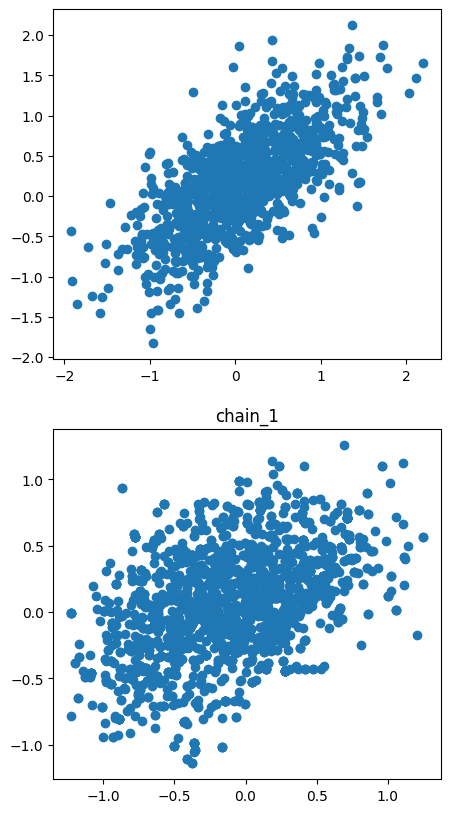

In [18]:
BenchmarkUtils.create_plot(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

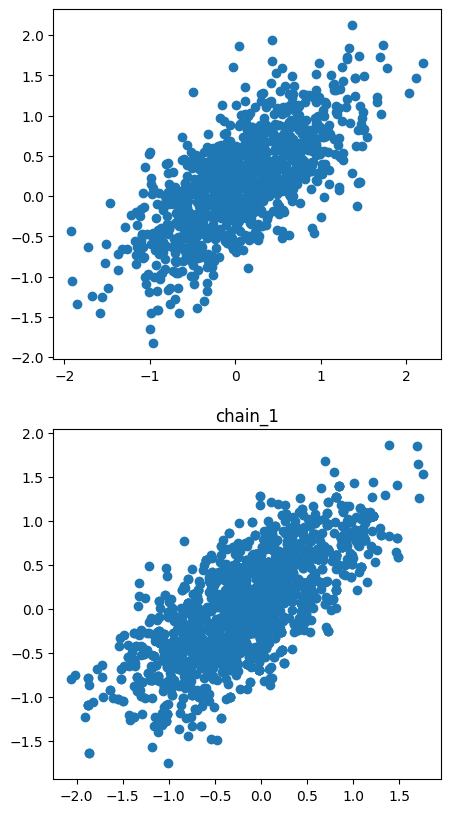

In [19]:
BenchmarkUtils.create_plot(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

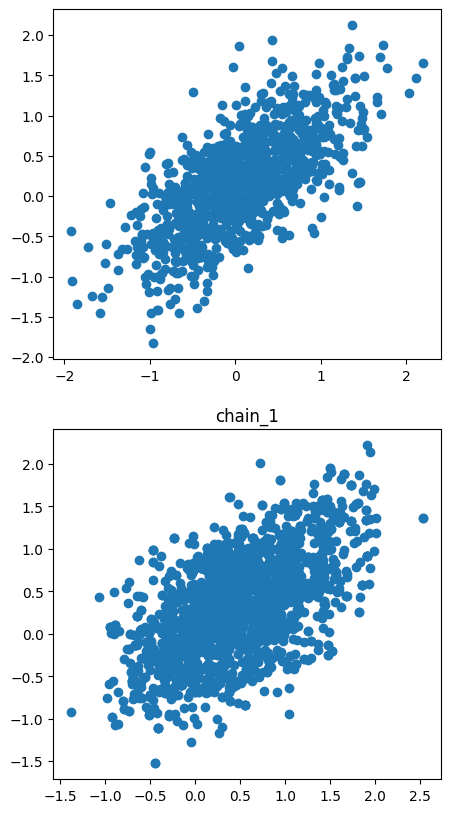

In [20]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [3], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

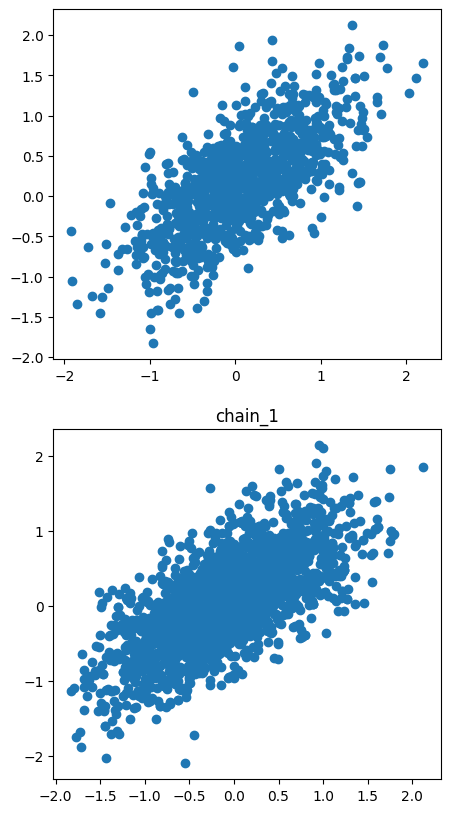

In [8]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [3], :],
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
tv_threshold = 0.05

In [ ]:
pure_runtime

In [ ]:
runtime

In [ ]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [13]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.0067948736),
 'tv_mean': Array(0.24810244, dtype=float32),
 'tv_conf_sigma': Array(0.01740446, dtype=float32)}

In [14]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.15771995),
 'tv_mean': Array(0.21279192, dtype=float32),
 'tv_conf_sigma': Array(0.01760941, dtype=float32)}

In [15]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.028841477),
 'tv_mean': Array(0.18426676, dtype=float32),
 'tv_conf_sigma': Array(0.01668865, dtype=float32)}

In [16]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.047266655),
 'tv_mean': Array(0.18932113, dtype=float32),
 'tv_conf_sigma': Array(0.01694001, dtype=float32)}

In [ ]:
algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.sigma_prec

In [14]:
algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.params.entropy_weight.squeeze()

tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])

In [13]:
algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.params.penalty_weight.squeeze()

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10.])

In [8]:
prec = algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.params.prec[1].detach().numpy()
minv = prec @ prec.T

In [16]:
algs["hmcadaptive_hutch"].pipeline.sample_blocks[0].iteration.params.lf_step_size

2.0

In [17]:
algs["hmcadaptive_hutch"].pipeline.sample_blocks[1].iteration.params.lf_step_size

2.0

In [9]:
minv

array([[ 0.27653396, -0.02068096,  0.05590434, ...,  0.05518337,
         0.05521391,  0.04351289],
       [-0.02068096,  0.33228043, -0.00228077, ...,  0.01447695,
         0.00361242,  0.02756508],
       [ 0.05590434, -0.00228077,  0.30019996, ...,  0.03423164,
         0.04927668,  0.02844278],
       ...,
       [ 0.05518337,  0.01447695,  0.03423164, ...,  0.3131537 ,
         0.01068957,  0.07059442],
       [ 0.05521391,  0.00361242,  0.04927668, ...,  0.01068957,
         0.3163823 ,  0.03396103],
       [ 0.04351289,  0.02756508,  0.02844278, ...,  0.07059442,
         0.03396103,  0.26646647]], dtype=float32)

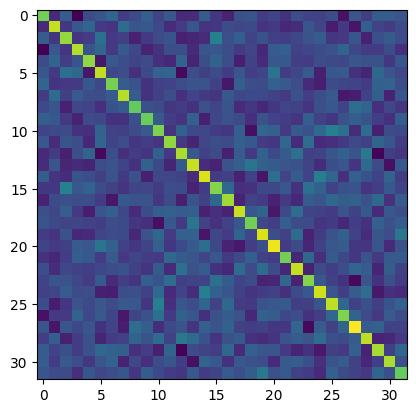

In [10]:
plt.imshow(minv)

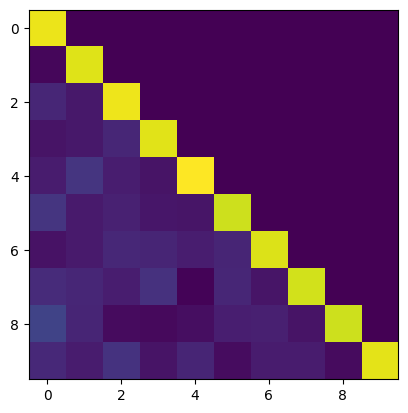

In [81]:
plt.imshow(algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.prec[0].detach().numpy())

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

In [5]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

{'ess': np.float32(0.018171519),
 'tv_mean': Array(0.16240993, dtype=float32),
 'tv_conf_sigma': Array(0.10823723, dtype=float32),
 'wasserstein': 2464.637656582231}

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)